In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn import tree
from sklearn import metrics as mtr

from IPython.display import Image as img
import subprocess

In [40]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.4f}'.format        

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
df = pd.read_csv('credit.csv')
df.info()

In [ ]:
df.head(10)

In [ ]:
df.isnull().sum()

In [ ]:
df[df == 0].count()

In [ ]:
df.nunique()

In [ ]:
for col in df.columns:
    if (df[col].nunique() < 10):
        print(col," : ",df[col].unique())

In [ ]:
df.drop(df[df.checking_balance == 'unknown'].index,axis=0,inplace=True)
df.drop(df[df.savings_balance == 'unknown'].index,axis=0,inplace=True)


In [ ]:
replaceStruct = {
    'checking_balance':{'< 0 DM':1, '1 - 200 DM':2, '> 200 DM':3},
    'credit_history':{'critical':1, 'poor':2, 'good':3, 'very good':4,'perfect':5},
    'savings_balance':{'< 100 DM':1,'100 - 500 DM':2, '500 - 1000 DM':3, '> 1000 DM':4 },
    'employment_duration':{'unemployed':0, '< 1 year':1, '1 - 4 years':2, '4 - 7 years':3, '> 7 years':4 },
    'job':{ 'unemployed':0, 'unskilled':1,'skilled':2, 'management':3},
    'phone':{'no':0,'yes':1},
    'default':{'no':0,'yes':1}
}

In [ ]:
df.replace(replaceStruct, inplace=True)

for col in df.columns:
    if (df[col].nunique() < 10):
        df[col] = df[col].astype('category')

df.head(10)

In [ ]:
# for col in df.columns:
#     if (df[col].nunique() < 10):
#         print(df[col].value_counts(),"\n")
       
df.info()

In [ ]:
df1 = df.drop(['purpose','housing'],axis=1).copy()

In [ ]:
df1 = pd.get_dummies(df1,columns=['other_credit'])
df1.info()

In [ ]:
df1.head(10)

In [ ]:
dfy = df1.default.copy()
dfX = df1.drop('default',axis=1).copy()

dfX_train, dfX_test, dfy_train,dfy_test = tts(dfX,dfy,test_size=0.3,random_state=600)

In [ ]:
dfy_test.value_counts(normalize=True)*100

In [42]:
dtree = dtc(criterion='gini',random_state=600)
dtree.fit(dfX_train,dfy_train)
print(dtree.score(dfX_train,dfy_train))
print(dtree.score(dfX_test,dfy_test))

1.0
0.6560509554140127


In [ ]:
y_pred = dtree.predict(dfX_test)
cmat = mtr.confusion_matrix(dfy_test,y_pred, labels=[1,0])
dfcm = pd.DataFrame(cmat, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

In [ ]:
char_labels = ['N','Y']
dtree_file = open('credit_tree.dot','w')
dot_data = tree.export_graphviz(dtree, out_file=dtree_file, feature_names=list(dfX_train), class_names=list(char_labels),
                               label='all', filled=True, rounded=True )
dtree_file.close()

In [ ]:
retcode = subprocess.call('dot -Tpng credit_tree.dot -o credit_tree.png',shell=True)
if(retcode > 0):
    print('Error running Graphviz; error code: ', str(retcode))
else:
    display(img('credit_tree.png'))


In [49]:
dtree1 = dtc(criterion='gini', max_depth=12, random_state=600)
dtree1.fit(dfX_train,dfy_train)
print(dtree1.score(dfX_train,dfy_train))
print(dtree1.score(dfX_test,dfy_test))

0.9671232876712329
0.6942675159235668


In [ ]:
dtree_file1 = open('credit_tree1.dot','w')
dot_data1 = tree.export_graphviz(dtree1, out_file=dtree_file1, feature_names=list(dfX_train), class_names=list(char_labels),
                               label='all', filled=True, rounded=True )
dtree_file1.close()

retcode = subprocess.call('dot -Tpng credit_tree1.dot -o credit_tree1.png',shell=True)
if(retcode > 0):
    print('Error running Graphviz; error code: ', str(retcode))
else:
    display(img('credit_tree1.png'))


In [ ]:
print(pd.DataFrame(dtree1.feature_importances_, columns=['Imp'],index=dfX_train.columns).sort_values('Imp',ascending=False))

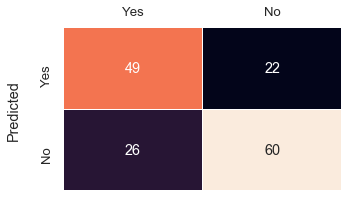

In [46]:
y_pred1 = dtree1.predict(dfX_test)
cmat1 = mtr.confusion_matrix(dfy_test,y_pred1, labels=[1,0])
dfcm1 = pd.DataFrame(cmat1, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm1, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()


# Ensemble Techniques

## Bagging (Bootstrap Aggregating)

In [60]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50,random_state=10)

bgcl = bgcl.fit(dfX_train, dfy_train)
print(bgcl.score(dfX_train , dfy_train))
print(bgcl.score(dfX_test , dfy_test))

1.0
0.7006369426751592


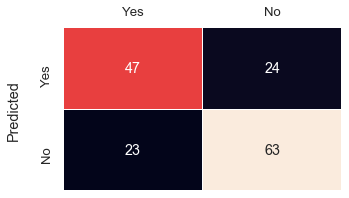

In [61]:
y_pred2 = bgcl.predict(dfX_test)
cmat2 = mtr.confusion_matrix(dfy_test,y_pred2, labels=[1,0])
dfcm2 = pd.DataFrame(cmat2, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm2, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

## AdaBoosting (Adaptive Boosting)

In [80]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators=70, random_state=6)

abcl = abcl.fit(dfX_train, dfy_train)
print(abcl.score(dfX_train , dfy_train))
print(abcl.score(dfX_test , dfy_test))

0.7917808219178082
0.6815286624203821


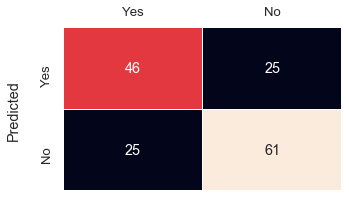

In [81]:
y_pred3 = abcl.predict(dfX_test)
cmat3 = mtr.confusion_matrix(dfy_test,y_pred3, labels=[1,0])
dfcm3 = pd.DataFrame(cmat3, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm3, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

## Gradient Boosting

In [99]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 70,random_state=6)
gbcl = gbcl.fit(dfX_train, dfy_train)

print(gbcl.score(dfX_train , dfy_train))
print(gbcl.score(dfX_test , dfy_test))

0.8931506849315068
0.6815286624203821


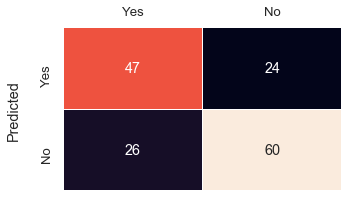

In [100]:
y_pred4 = gbcl.predict(dfX_test)
cmat4 = mtr.confusion_matrix(dfy_test,y_pred4, labels=[1,0])
dfcm4 = pd.DataFrame(cmat4, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm4, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

## RandomForest

In [138]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 5, random_state=6,max_features=6)
rfcl = rfcl.fit(dfX_train, dfy_train)

print(rfcl.score(dfX_train , dfy_train))
print(rfcl.score(dfX_test , dfy_test))

0.9643835616438357
0.7133757961783439


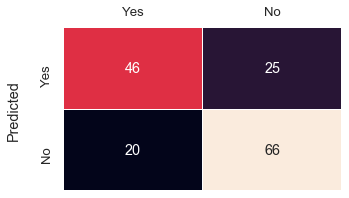

In [139]:
y_pred5 = rfcl.predict(dfX_test)
cmat5 = mtr.confusion_matrix(dfy_test,y_pred5, labels=[1,0])
dfcm5 = pd.DataFrame(cmat5, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm5, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()